# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

In [78]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [3]:
churn.shape

(46206, 21)

In [4]:
churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
count,46206.000000,46206.000000,46206.000000,46130.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,28416.000000,28416.000000,28416.000000
mean,42335.196879,45.874627,1.555707,41.411836,50.318617,51.364858,10.846708,8.237112,20.349825,15.249968,0.385015,75.188029,0.014640,0.191125,0.007038
std,22100.432751,33.077927,0.835529,15.263726,51.925537,20.855419,9.769887,8.341476,8.034631,10.982958,0.486604,73.519041,0.120108,0.393194,0.083600
min,1.000000,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000,0.000000,0.000000,0.000000
25%,24951.750000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000,0.000000,0.000000,0.000000
50%,43261.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000,0.000000,0.000000,0.000000
75%,61132.750000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000,0.000000,0.000000,0.000000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000,1.000000,1.000000,1.000000


In [48]:
churn['CHURN_IND'].unique()

array([1, 0], dtype=int64)

There were only two type of churn idn which were 0 and 1.

In [49]:
churn['CHURN_IND'].value_counts()

0    28416
1    17790
Name: CHURN_IND, dtype: int64

After the calculation, we know how many churn idn with 0 and 1.

In [50]:
churn.isna()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46202,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
46203,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
46204,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [51]:
churn.isna().sum()

CUST_ID                             0
ACCOUNT_TENURE                      0
ACCT_CNT_SERVICES                   0
AGE                                76
CFU                                 0
SERVICE_TENURE                      0
PLAN_ACCESS_FEE                     0
BYO_PLAN_STATUS                     0
PLAN_TENURE                         0
MONTHS_OF_CONTRACT_REMAINING        0
LAST_FX_CONTRACT_DURATION           0
CONTRACT_STATUS                     0
PREV_CONTRACT_DURATION              0
HANDSET_USED_BRAND                  0
CHURN_IND                           0
MONTHLY_SPEND                       0
COUNTRY_METRO_REGION                1
STATE                               1
RECON_SMS_NEXT_MTH              17790
RECON_TELE_NEXT_MTH             17790
RECON_EMAIL_NEXT_MTH            17790
dtype: int64

There were too many NaN values in this dataframe especially in all three recon column. Moreover, there were some in the age, country metro region and state.

In [52]:
churn.isna().any(1).values

array([ True,  True,  True, ..., False, False, False])

In [53]:
nan_value = np.where(churn.isna().any(1).values)

In [54]:
new_churn = churn.drop(['RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], axis=1)
new_churn.shape

(46206, 18)

We then drop the recon sms, tele and email cause they were useless and cannot be applied to this prediction model.

In [55]:
new_churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW


In [56]:
new_churn['CFU'] = new_churn['CFU'].rank(method='dense')-1
new_churn['BYO_PLAN_STATUS'] = new_churn['BYO_PLAN_STATUS'].rank(method='dense')-1
new_churn['CONTRACT_STATUS'] = new_churn['CONTRACT_STATUS'].rank(method='dense')-1
new_churn['HANDSET_USED_BRAND'] = new_churn['HANDSET_USED_BRAND'].rank(method='dense')-1
new_churn['COUNTRY_METRO_REGION'] = new_churn['COUNTRY_METRO_REGION'].rank(method='min')-1
new_churn['STATE'] = new_churn['STATE'].rank(method='min')-1

We also replaced and categorized the other columns that contain words with rank in order to calculate afterward.

In [57]:
new_churn

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,0.0,46,54.54,1.0,15,0,24,1.0,24,4.0,1,61.40,0.0,42345.0
2,2,60,3,55.0,0.0,59,54.54,1.0,5,0,24,1.0,24,0.0,1,54.54,14379.0,1003.0
3,5,65,1,29.0,0.0,65,40.90,0.0,15,0,12,1.0,12,0.0,1,2.50,0.0,42345.0
4,6,31,1,51.0,0.0,31,31.81,1.0,31,0,24,1.0,24,0.0,1,6.48,0.0,29835.0
5,8,95,1,31.0,0.0,95,54.54,1.0,0,0,24,1.0,24,0.0,1,100.22,14379.0,1003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46202,79494,10,1,61.0,0.0,9,27.27,0.0,7,0,0,0.0,0,3.0,0,27.27,0.0,29835.0
46203,79495,2,1,53.0,0.0,2,54.54,1.0,2,0,24,1.0,24,5.0,1,54.99,14379.0,1003.0
46204,79496,47,1,22.0,0.0,47,72.72,1.0,7,17,24,2.0,24,0.0,0,72.72,0.0,1003.0


In [58]:
new_churn = new_churn.fillna(0)

Filling up all the NaN values with 0 in new_churn.

In [60]:
new_churn.dtypes

CUST_ID                           int64
ACCOUNT_TENURE                    int64
ACCT_CNT_SERVICES                 int64
AGE                             float64
CFU                             float64
SERVICE_TENURE                    int64
PLAN_ACCESS_FEE                 float64
BYO_PLAN_STATUS                 float64
PLAN_TENURE                       int64
MONTHS_OF_CONTRACT_REMAINING      int64
LAST_FX_CONTRACT_DURATION         int64
CONTRACT_STATUS                 float64
PREV_CONTRACT_DURATION            int64
HANDSET_USED_BRAND              float64
CHURN_IND                         int64
MONTHLY_SPEND                   float64
COUNTRY_METRO_REGION            float64
STATE                           float64
dtype: object

By checking the data type, we noticed that the rank method changed all objects into float 64. However, float 64 is not supported by logistic regression.

In [62]:
new_churn['AGE'] = new_churn['AGE'].astype(np.float16)
new_churn['CFU'] = new_churn['CFU'].astype(np.float16)
new_churn['PLAN_ACCESS_FEE'] = new_churn['PLAN_ACCESS_FEE'].astype(np.float16)
new_churn['BYO_PLAN_STATUS'] = new_churn['BYO_PLAN_STATUS'].astype(np.float16)
new_churn['CONTRACT_STATUS'] = new_churn['CONTRACT_STATUS'].astype(np.float16)
new_churn['HANDSET_USED_BRAND'] = new_churn['HANDSET_USED_BRAND'].astype(np.float16)
new_churn['MONTHLY_SPEND'] = new_churn['MONTHLY_SPEND'].astype(np.float16)
new_churn['COUNTRY_METRO_REGION'] = new_churn['COUNTRY_METRO_REGION'].astype(np.float16)
new_churn['STATE'] = new_churn['STATE'].astype(np.float16)

We then changed all float 64 into float 16 with astype function.

In [63]:
new_churn.dtypes

CUST_ID                           int64
ACCOUNT_TENURE                    int64
ACCT_CNT_SERVICES                 int64
AGE                             float16
CFU                             float16
SERVICE_TENURE                    int64
PLAN_ACCESS_FEE                 float16
BYO_PLAN_STATUS                 float16
PLAN_TENURE                       int64
MONTHS_OF_CONTRACT_REMAINING      int64
LAST_FX_CONTRACT_DURATION         int64
CONTRACT_STATUS                 float16
PREV_CONTRACT_DURATION            int64
HANDSET_USED_BRAND              float16
CHURN_IND                         int64
MONTHLY_SPEND                   float16
COUNTRY_METRO_REGION            float16
STATE                           float16
dtype: object

In [64]:
new_churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,0.0,46,54.53125,1.0,15,0,24,1.0,24,4.0,1,61.406250,0.0,42336.0
2,2,60,3,55.0,0.0,59,54.53125,1.0,5,0,24,1.0,24,0.0,1,54.531250,14384.0,1004.0
3,5,65,1,29.0,0.0,65,40.90625,0.0,15,0,12,1.0,12,0.0,1,2.500000,0.0,42336.0
4,6,31,1,51.0,0.0,31,31.81250,1.0,31,0,24,1.0,24,0.0,1,6.480469,0.0,29840.0
5,8,95,1,31.0,0.0,95,54.53125,1.0,0,0,24,1.0,24,0.0,1,100.250000,14384.0,1004.0


In [65]:
new_churn.isna().sum()

CUST_ID                         0
ACCOUNT_TENURE                  0
ACCT_CNT_SERVICES               0
AGE                             0
CFU                             0
SERVICE_TENURE                  0
PLAN_ACCESS_FEE                 0
BYO_PLAN_STATUS                 0
PLAN_TENURE                     0
MONTHS_OF_CONTRACT_REMAINING    0
LAST_FX_CONTRACT_DURATION       0
CONTRACT_STATUS                 0
PREV_CONTRACT_DURATION          0
HANDSET_USED_BRAND              0
CHURN_IND                       0
MONTHLY_SPEND                   0
COUNTRY_METRO_REGION            0
STATE                           0
dtype: int64

Check if we miss any NaN values.

In [66]:
train, test = train_test_split(new_churn, test_size=0.2, random_state=50)
print(train.shape, test.shape)

(36964, 18) (9242, 18)


Now we split new_churn into 80% and 20% for train set and test setrespectively.

In [67]:
x_train = train.drop(['CUST_ID', 'CHURN_IND'], axis=1)
y_train = train['CHURN_IND']
x_test = test.drop(['CUST_ID', 'CHURN_IND'], axis=1)
y_test = test['CHURN_IND']
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(36964, 16) (36964,) (9242, 16) (9242,)


In [69]:
model = LogisticRegression(solver='lbfgs',max_iter=25000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=25000)

We then increase the max iteration of logistic regression because it is only 100 by default which is not enough for our case.

In [73]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

By using predict function, we get the prediction of both x train and x test.

In [74]:
print("Accuracy on training set: ", accuracy_score(y_train, pred_train))
print("Accuracy on testing set: ", accuracy_score(y_test, pred_test))

Accuracy on training set:  0.7105562168596472
Accuracy on testing set:  0.706989829041333


With the help sklearn, we also calculated the accuracy score of both test and train prediction.

In [75]:
confusion_train = confusion_matrix(y_train, pred_train)
confusion_test = confusion_matrix(y_test, pred_test)

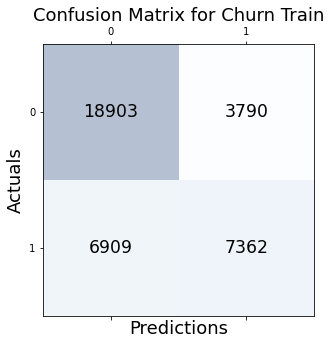

In [76]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion_train, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        ax.text(x=j, y=i,s=confusion_train[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Churn Train', fontsize=18)
plt.show()

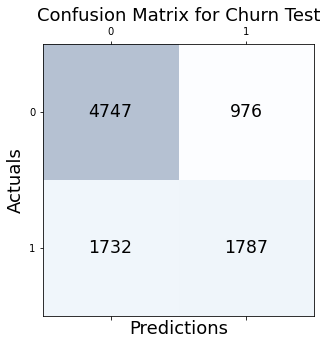

In [77]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion_test, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_test.shape[0]):
    for j in range(confusion_test.shape[1]):
        ax.text(x=j, y=i,s=confusion_test[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Churn Test', fontsize=18)
plt.show()

At last, the confusion matrix give us a plot that show how accurate our prediction will be. Although there are quite a few of prediction predict that some customers will have churn idn of 0, in reality those customers had churn idn of 1. However, most of the customers were in the correct prediction which is churn idn of 0.

In conclusion, the accuracy of test and train set are 70.7% and 71% respectively. As the confusion matrix graph shows that the prediction of customer having shurn idn of 0 and 1 are also the same number in actuals. For recommendation, more information will be need for a more accurate prediction model such as customer's income , preferrable mobile phone brand, the reason and feedback of choosing their mobile provider.